In [675]:
from pyhive import presto
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython import display
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import re

## Set up the Presto connection 

In [676]:
presto_conn = presto.connect(
     host='localhost',
     port=8880,
     catalog='hive',
     schema='default'
 )
presto_cur = presto_conn.cursor()

## Query data from the focused_tweets_forquery table using Presto

In [677]:
presto_cur.execute('show tables')
print(presto_cur.fetchall())

presto_cur.execute('SELECT * FROM default.focused_tweets_forquery')   

[('focused_tweets_forquery',)]


## Convert the raw data to Pandas dataframe called "df" with the selected fields

In [678]:
df = pd.DataFrame(presto_cur.fetchall())
df.columns = ['author_id','tweet_id','tweet_created_at','retweet_count','reply_count','like_count','user_location','user_fullname','username','tweet_text','hashtag_name','url']
print(df.shape)
df.head()

(2967, 12)


,author_id,tweet_id,tweet_created_at,retweet_count,reply_count,like_count,user_location,user_fullname,username,tweet_text,hashtag_name,url
0,1467696317954670596,3246390180,2021-12-06T03:24:05.000Z,0,0,0,"[A safe distance from you, Montréal, Québec]","[hs88, Steven Guilbeault]","[hs88_hs88, s_guilbeault]",@s_guilbeault We’ve compromised for far too long. Time to make change before the cost of doing so will be even more drastic.,[],[]
1,1467696319493861377,1454257101379825664,2021-12-06T03:24:05.000Z,0,0,0,"[San Diego, CA, West Virginia, USA, None]","[Susan Lewitt, Senator Joe Manchin, Shelley Moore Capito]","[LewittSusan, Sen_JoeManchin, SenCapito]",RT: .@Sen_JoeManchin .@SenCapito If we dare to say we love our children we must be willing to back that up and #ActOnClimate #BuildBackBetter RT:\...,"[ActOnClimate, BuildBackBetter]",[https://t.co/OcSCDHDhTb]
2,1467696321477984257,1250658326,2021-12-06T03:24:06.000Z,179,0,0,"[Kentucky, USA, Nashville, TN]","[Dirty South 13, John Rich]","[gbky1, johnrich]",RT @johnrich: We must stop global warming before Hawaii freezes over.,[],[]
3,1467696334752862211,913966037502062593,2021-12-06T03:24:09.000Z,0,0,0,"[Denver, CO, New Zealand]","[MarkS, Kevin Pluck💉²]","[DataMatters22, kevpluck]",@kevpluck A link to his recent video\nhttps://t.co/bFU0GkXYYA\n#Climate \n#ClimateAction \n#ClimateBrawl \n#ClimateCrisis,"[Climate, ClimateAction, ClimateBrawl, ClimateCrisis]",[https://t.co/bFU0GkXYYA]
4,1467696335134416896,1355703528,2021-12-06T03:24:09.000Z,0,0,0,"[SYDNEY, Hobart, Tasmania, None, Sydney, Australia]","[BC, Doug Cameron, Chris Bowen, Anthony Albanese]","[BGJC1970, DougCameron51, Bowenchris, AlboMP]","@DougCameron51 @Bowenchris @AlboMP get your hand off it Doug....maybe get some fresh faces in your ranks, the embittered union/local council/media...",[],"[Doug....maybe, drivel.....]"


## Cleanse and transform data as needed to produce the final version of df to query from

In [679]:
def final_table(df):
    df_copy = df.copy()
    df_user = df_copy[['user_location','user_fullname','username']].applymap(lambda x: x[0])     # create a new df called "df_user" for these 3 columns with the 1st element of each array
    df_copy.drop(columns=['user_location','user_fullname','username'],inplace=True)              # drop these columns from the "df_copy"
    df_new = pd.concat([df_copy, df_user], axis=1)                                               # concat "df_copy" and "df_user" dataframes in column-wise
    df_new = df_new[['author_id','tweet_id','tweet_created_at','retweet_count','reply_count','like_count','user_location','user_fullname','username','tweet_text','hashtag_name','url']]
    
    mask = df_new['hashtag_name'].notnull()
    df_new.loc[mask,'hashtag_name'] = [', '.join(map(str,x)) for x in df_new.loc[mask,'hashtag_name']]    # convert a single array of values in each cell to a comma-separated single string 
    return df_new

final_df = final_table(df)
print(final_df.shape)
final_df.head(10)

(2967, 12)


,author_id,tweet_id,tweet_created_at,retweet_count,reply_count,like_count,user_location,user_fullname,username,tweet_text,hashtag_name,url
0,1467696317954670596,3246390180,2021-12-06T03:24:05.000Z,0,0,0,A safe distance from you,hs88,hs88_hs88,@s_guilbeault We’ve compromised for far too long. Time to make change before the cost of doing so will be even more drastic.,,[]
1,1467696319493861377,1454257101379825664,2021-12-06T03:24:05.000Z,0,0,0,"San Diego, CA",Susan Lewitt,LewittSusan,RT: .@Sen_JoeManchin .@SenCapito If we dare to say we love our children we must be willing to back that up and #ActOnClimate #BuildBackBetter RT:\...,"ActOnClimate, BuildBackBetter",[https://t.co/OcSCDHDhTb]
2,1467696321477984257,1250658326,2021-12-06T03:24:06.000Z,179,0,0,"Kentucky, USA",Dirty South 13,gbky1,RT @johnrich: We must stop global warming before Hawaii freezes over.,,[]
3,1467696334752862211,913966037502062593,2021-12-06T03:24:09.000Z,0,0,0,"Denver, CO",MarkS,DataMatters22,@kevpluck A link to his recent video\nhttps://t.co/bFU0GkXYYA\n#Climate \n#ClimateAction \n#ClimateBrawl \n#ClimateCrisis,"Climate, ClimateAction, ClimateBrawl, ClimateCrisis",[https://t.co/bFU0GkXYYA]
4,1467696335134416896,1355703528,2021-12-06T03:24:09.000Z,0,0,0,SYDNEY,BC,BGJC1970,"@DougCameron51 @Bowenchris @AlboMP get your hand off it Doug....maybe get some fresh faces in your ranks, the embittered union/local council/media...",,"[Doug....maybe, drivel.....]"
5,1467696331565248521,3158022289,2021-12-06T03:24:08.000Z,119,0,0,Texas,Ronny Sawyer,SprinklerRs,"RT @1Pammsy: Oh but, but Joe, AOC and the gang said climate change is because of USA and our Co2 emissions…hence electric cars! Joe lied ag…",,[]
6,1467696338418601995,1342937111956049920,2021-12-06T03:24:10.000Z,0,0,0,Norse Pole.,Zapsavvy,Ambera88371847,@s_guilbeault Not this Canadian.,,[]
7,1467696347381907461,1227335449749921793,2021-12-06T03:24:12.000Z,0,0,0,None,The Kitchen Sink,TheKitchennsink,"“There’s no such thing as global warming, it’ll get colder, you watch” - Donald Trump like a million times…well Mar-a-Lardo, in Kentucky we have p...",,[]
8,1467696349818892289,471187104,2021-12-06T03:24:12.000Z,0,0,0,"Toronto, Ontario",Michael Rouben,mrouben,@SoccerMomTrades The absolute worst. And we pay massive premium in housing for the privilege of shoveling driveways while freezing our asses off h...,,[]
9,1467696351714500614,17860119,2021-12-06T03:24:13.000Z,0,0,0,"Winters in FL, Summers in AZ",Bill Johnston,CapitanBilly,@mhklein57 @GOP Climate Change? You mean the Earth's climate that has been changing for millions of years before humans were here??,,[]


In [680]:
pd.options.display.max_colwidth = 150                       # comment this out if we want a pretty print and less than 150 characters
print(final_df[:10].tweet_text.to_string(index=False))

                          @s_guilbeault We’ve compromised for far too long. Time to make change before the cost of doing so will be even more drastic.
RT: .@Sen_JoeManchin .@SenCapito If we dare to say we love our children we must be willing to back that up and #ActOnClimate #BuildBackBetter RT:\n...
                                                                                 RT @johnrich: We must stop global warming before Hawaii freezes over.
                             @kevpluck A link to his recent video\nhttps://t.co/bFU0GkXYYA\n#Climate \n#ClimateAction \n#ClimateBrawl \n#ClimateCrisis
@DougCameron51 @Bowenchris @AlboMP get your hand off it Doug....maybe get some fresh faces in your ranks, the embittered union/local council/media ...
          RT @1Pammsy: Oh but, but Joe, AOC and the gang said climate change is because of USA and our Co2 emissions…hence electric cars! Joe lied ag…
                                                                                              

#### Original Twitter - Username:TheKitchennsink

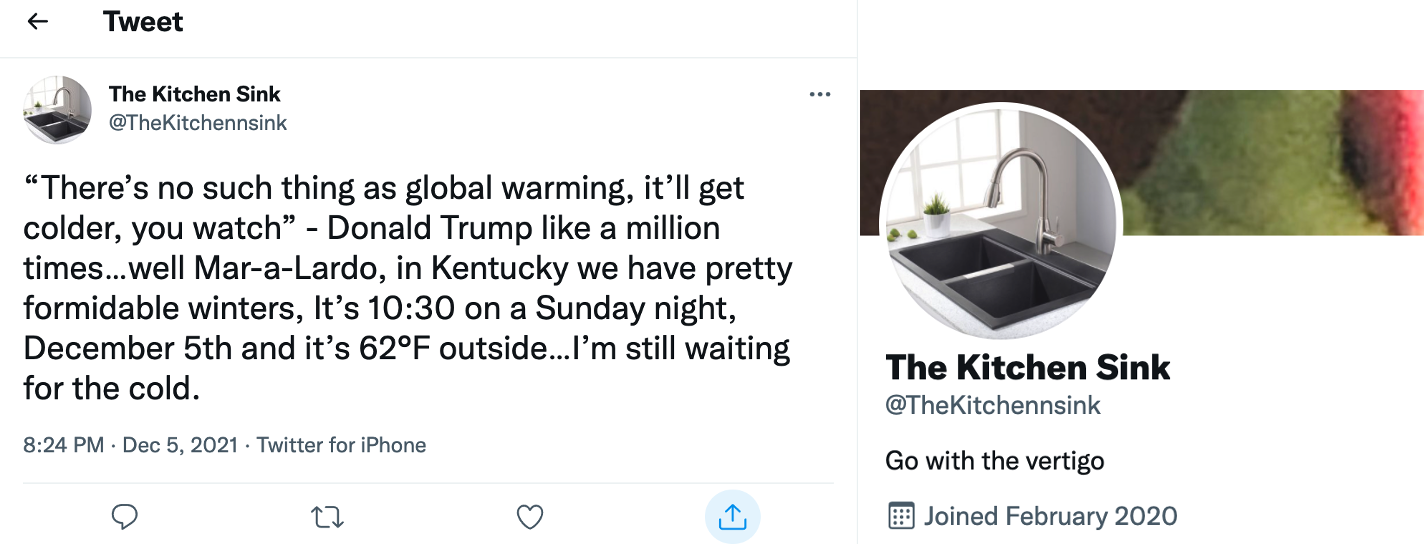

In [681]:
display.Image('Images/OrgTweet_TheKitchennsink.png')

#### Reply to Other Twitters - Username:BGJC1970

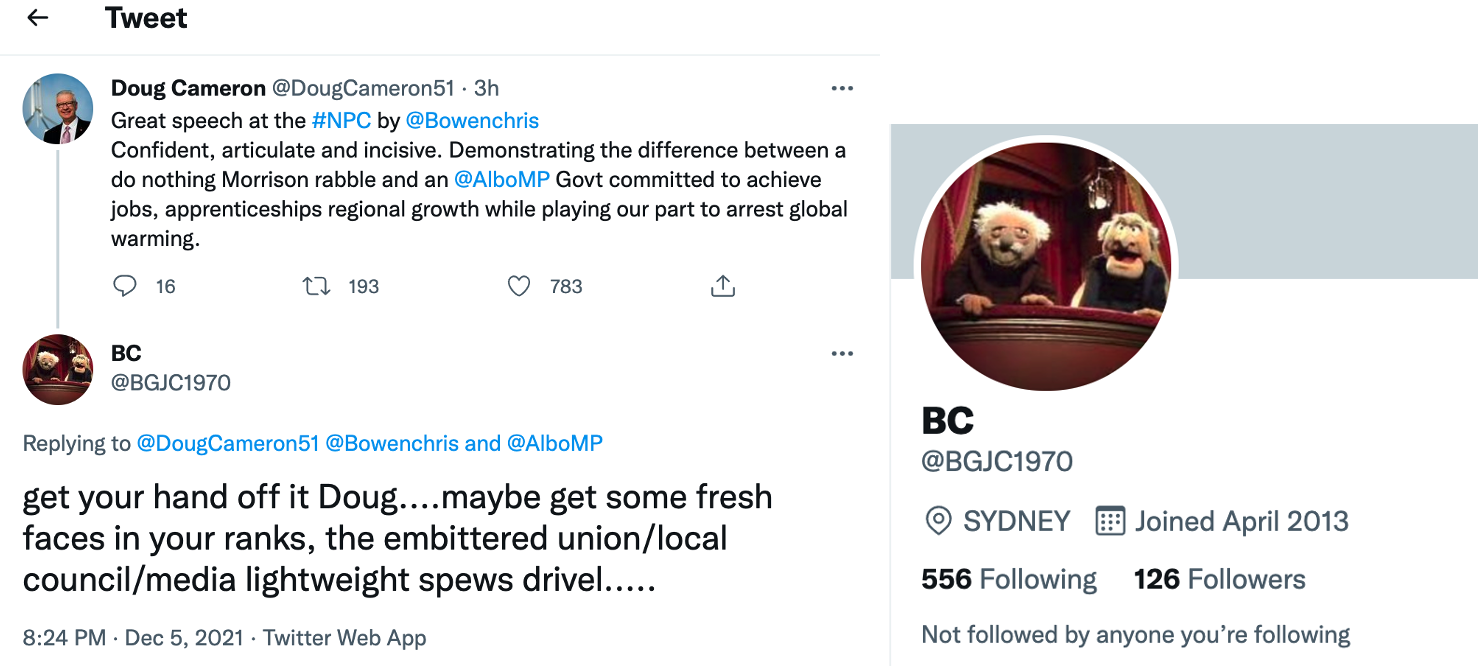

In [682]:
display.Image('Images/Reply_BGJC1970.png')

#### Retweeter to a specific tweet - Username:gbky1

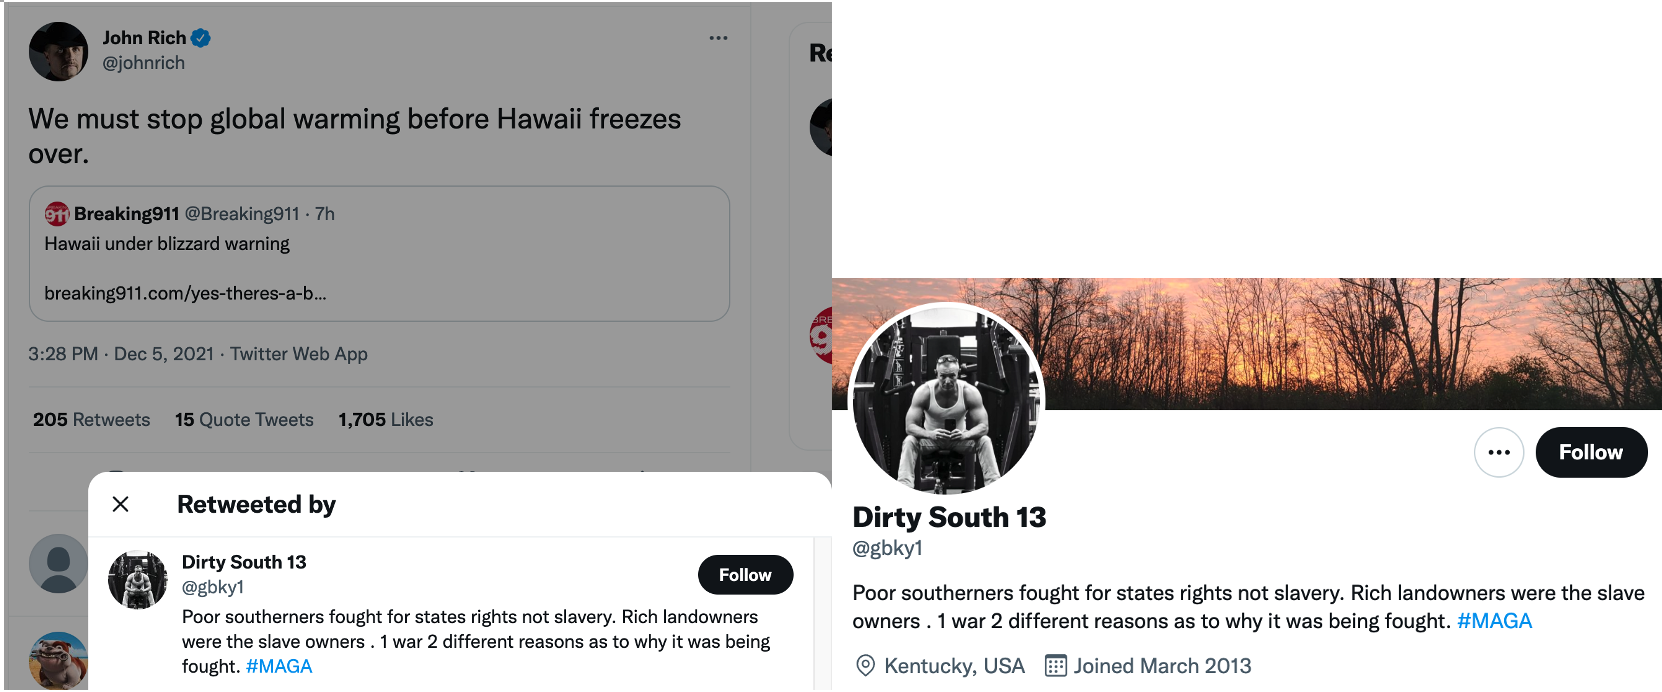

In [683]:
display.Image('Images/RT_gbky1.png')

# ANALYTICS WITH VISUALIZATIONS

## Q1. The Most Trending Words in the Entire Tweets

### Clean up the tweet_text column to generate the word cloud

In [684]:
def clean_text(df):
    df_only_text = df[['tweet_text']].copy()
    dict_special_char = {'#':'', 'RT':''}
    df_only_text.replace(dict_special_char, regex=True, inplace=True)
    df_only_text['text_no_links'] = df_only_text['tweet_text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
    df_only_text['text_no_username'] = df_only_text['text_no_links'].apply(lambda x:re.sub("@[A-Za-z0-9]+","", str(x)))
    return df_only_text

df_text_cleaned = clean_text(final_df)
df_text_cleaned.head()

,tweet_text,text_no_links,text_no_username
0,@s_guilbeault We’ve compromised for far too long. Time to make change before the cost of doing so will be even more drastic.,@s_guilbeault We’ve compromised for far too long. Time to make change before the cost of doing so will be even more drastic.,_guilbeault We’ve compromised for far too long. Time to make change before the cost of doing so will be even more drastic.
1,: .@Sen_JoeManchin .@SenCapito If we dare to say we love our children we must be willing to back that up and ActOnClimate BuildBackBetter :\nhttps...,: .@Sen_JoeManchin .@SenCapito If we dare to say we love our children we must be willing to back that up and ActOnClimate BuildBackBetter :\n,: ._JoeManchin . If we dare to say we love our children we must be willing to back that up and ActOnClimate BuildBackBetter :\n
2,@johnrich: We must stop global warming before Hawaii freezes over.,@johnrich: We must stop global warming before Hawaii freezes over.,: We must stop global warming before Hawaii freezes over.
3,@kevpluck A link to his recent video\nhttps://t.co/bFU0GkXYYA\nClimate \nClimateAction \nClimateBrawl \nClimateCrisis,@kevpluck A link to his recent video\n,A link to his recent video\n
4,"@DougCameron51 @Bowenchris @AlboMP get your hand off it Doug....maybe get some fresh faces in your ranks, the embittered union/local council/media...","@DougCameron51 @Bowenchris @AlboMP get your hand off it Doug....maybe get some fresh faces in your ranks, the embittered union/local council/media...","get your hand off it Doug....maybe get some fresh faces in your ranks, the embittered union/local council/media lightweight spews drivel....."


### Generate the word cloud and visualize the most trending words

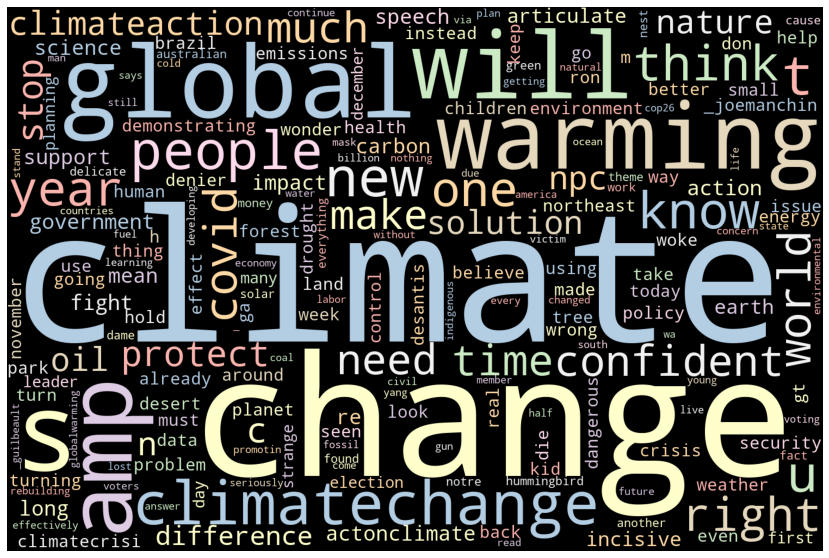

In [685]:
def word_cloud(df):
    text = " ".join(word for word in df.text_no_username.astype(str)).lower()
    stop_words = ['say','said','want','thank','really','good','great','well','see','hello','now','got','let', 'ah', 'yeah', 'oh', 'ooh', 'im'] + list(STOPWORDS)
    word_cloud = WordCloud(stopwords=stop_words, background_color='black', colormap='Pastel1', collocations=False, width=1500, height=1000).generate(text)
    
    plt.figure(figsize=(20,10))
    plt.imshow(word_cloud)
    plt.axis('off')
    
word_cloud(df_text_cleaned)

## Q2. Top 5 Most Active Usernames

In [686]:
top_5_active_usernames = final_df['username'].value_counts()[:5].rename_axis('username').reset_index(name='freq_count')
top_5_active_usernames

,username,freq_count
0,JFSebastian146,26
1,Eco1stArt,21
2,Leslie27059464,20
3,LewittSusan,18
4,PetWrites,15


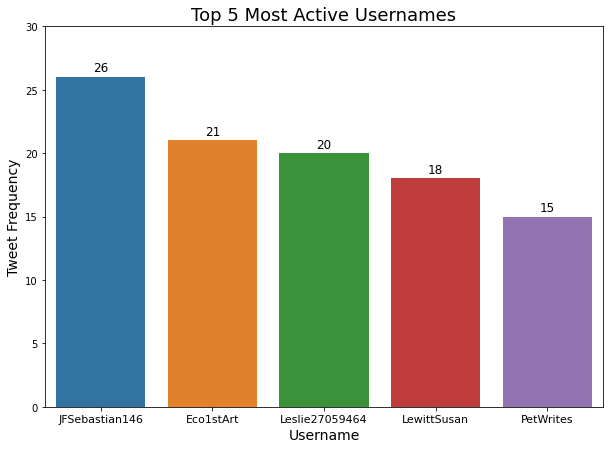

In [687]:
plt.figure(figsize=(10,7))
ax=sns.barplot(x=top_5_active_usernames.username.tolist(),
               y=top_5_active_usernames.freq_count.tolist())
plt.xlabel('Username', fontsize=14)
plt.ylabel('Tweet Frequency', fontsize=14)
plt.title('Top 5 Most Active Usernames', fontsize=18)
plt.ylim(0,30)
new_style = {'grid': False}
mpl.rc('axes', **new_style)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
               (p.get_x() + p.get_width()/2., 
                p.get_height()), ha='center', va='center', size=12, xytext=(0,9),
               textcoords = 'offset points', fontsize=12);

## Q3. Top 5 Trending Hashtag Names

In [688]:
count_hashtag = final_df['hashtag_name'].str.lower().str.split(',\s+', expand=True).stack().value_counts()[1:6].rename_axis('hashtag_name').reset_index(name='freq_count')
count_hashtag

,hashtag_name,freq_count
0,climatechange,196
1,climateaction,72
2,actonclimate,64
3,npc,64
4,climatecrisis,59


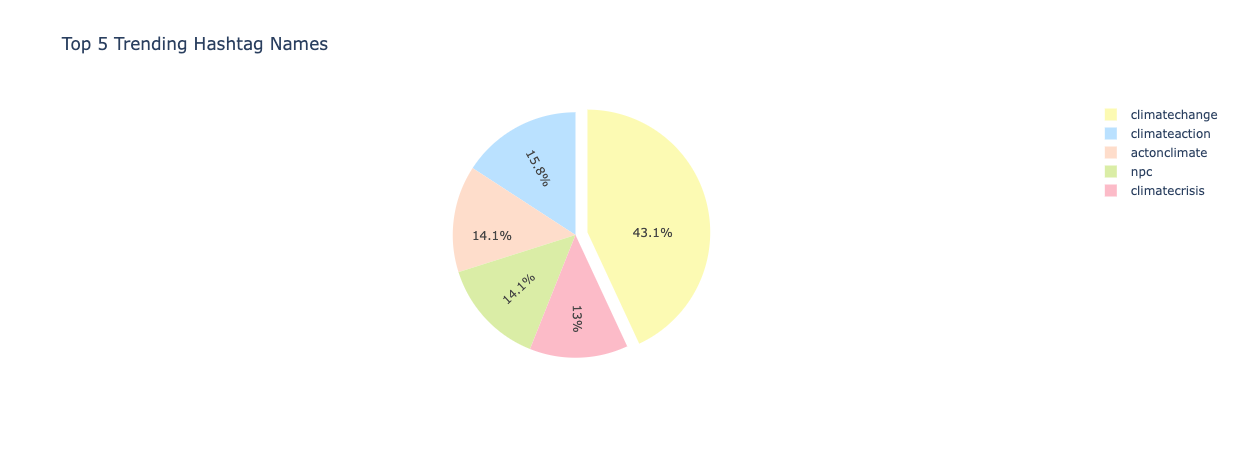

In [689]:
import plotly.graph_objects as go

labels = count_hashtag.hashtag_name.tolist()
values = count_hashtag.freq_count.tolist()
pastel_colors = ['#fcfab3','#bae1ff', '#feddcb','#daeda6', '#fcbbc8']

fig = go.Figure(data=[go.Pie(labels=labels, values=values, pull=[0.1, 0,0,0,0], textinfo='percent', marker_colors=pastel_colors,
                            insidetextorientation='radial')])
fig.update_layout(title_text='Top 5 Trending Hashtag Names')
fig.show()

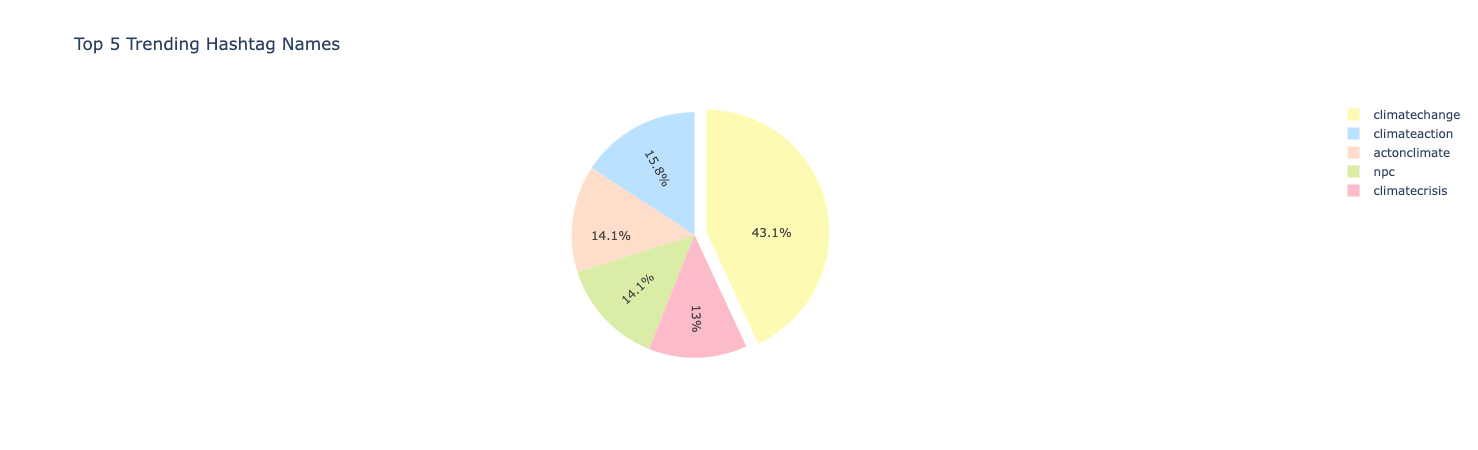

In [690]:
display.Image('Images/top5_hashtag_pieChart.png')

## Q4. Top 10 Tweets with the Most Retweets

In [691]:
def tweets_with_retweet(df):
    df = df[(df['retweet_count'] != 0)].sort_values(by='retweet_count',ascending=False)
#     top10_tweets_with_retweet = df.head(10).reset_index(drop=True)
    new_df = df[['tweet_id','username','retweet_count', 'tweet_text']]
    return new_df.reset_index(drop=True)

top10_tweets_with_retweet = tweets_with_retweet(final_df).head(10)
top10_tweets_with_retweet

,tweet_id,username,retweet_count,tweet_text
0,188945540,kalkua1,13701,"RT @GretaThunberg: A reminder: the people in power don’t need conferences, treaties or agreements to start taking real climate action. They…"
1,1143501985557049345,OdzrtcySsIPXdoT,13700,"RT @GretaThunberg: A reminder: the people in power don’t need conferences, treaties or agreements to start taking real climate action. They…"
2,263209076,She_Won_TRUTH,7300,RT @staceyabrams: CALIFORNIANS: My friend @GavinNewsom needs your support to stop the Republican recall.\n\nVote no and return your ballot by…
3,15177772,jeffburdges,6041,"RT @BillyArmagh: Canada is a country that wakes up to find whole towns and key infrastructure destroyed by climate change, and the VERY FIR…"
4,2409959066,Adal_M_F,4511,"RT @notsweetdandy: Climate change for Jawbreakers, Double D https://t.co/pQiJDJMkia"
5,2321482045,BBfromPA,4280,RT @EmpireFiles: .@AbbyMartin confronts Nancy Pelosi at #COP26 for overseeing massive increases in the Pentagon budget—a bigger polluter th…
6,3241875014,milvtx,4082,RT @GuntherEagleman: RT if you know climate change is a hoax
7,827841877692997633,misty_gamblin,4081,RT @GuntherEagleman: RT if you know climate change is a hoax
8,1333725075284127744,AssangeHome,3514,RT @AbbyMartin: I asked Nancy Pelosi why she keeps expanding the US war machine while claiming to fight climate change at #COP26
9,2321482045,BBfromPA,3513,RT @AbbyMartin: I asked Nancy Pelosi why she keeps expanding the US war machine while claiming to fight climate change at #COP26


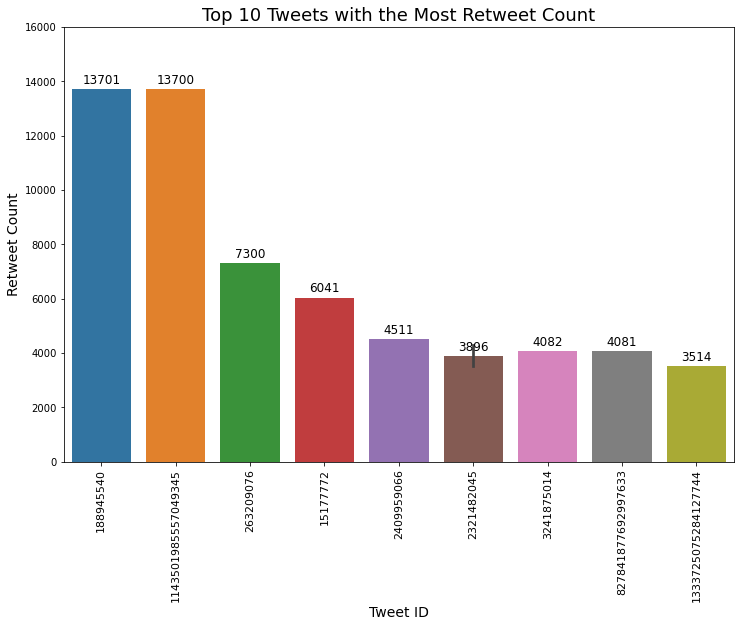

In [692]:
plt.figure(figsize=(12,8))
ax=sns.barplot(x=top10_tweets_with_retweet.tweet_id.tolist(),
               y=top10_tweets_with_retweet.retweet_count.tolist())
#               ci=None)
plt.xlabel('Tweet ID', fontsize=14)
plt.ylabel('Retweet Count', fontsize=14)
plt.title('Top 10 Tweets with the Most Retweet Count', fontsize=18)
plt.ylim(0,16000)
plt.xticks(rotation=90)
new_style = {'grid': False}
mpl.rc('axes', **new_style)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
               (p.get_x() + p.get_width()/2., 
                p.get_height()), ha='center', va='center', size=12, xytext=(0,9),
               textcoords = 'offset points', fontsize=12);

## Q5. The Most Trending Words in the Top 100 Tweets with the Most Retweets

In [693]:
top100_tweets_with_retweet = tweets_with_retweet(final_df).head(100)
top100_tweets_with_retweet['original_tweeters'] = top100_tweets_with_retweet['tweet_text'].str.extract(r'(RT\s+@\w{4,15})', expand=False)
top100_tweets_with_retweet.original_tweeters.replace("RT @","",regex=True, inplace=True)
top100_tweets_with_retweet

,tweet_id,username,retweet_count,tweet_text,original_tweeters
0,188945540,kalkua1,13701,"RT @GretaThunberg: A reminder: the people in power don’t need conferences, treaties or agreements to start taking real climate action. They…",GretaThunberg
1,1143501985557049345,OdzrtcySsIPXdoT,13700,"RT @GretaThunberg: A reminder: the people in power don’t need conferences, treaties or agreements to start taking real climate action. They…",GretaThunberg
2,263209076,She_Won_TRUTH,7300,RT @staceyabrams: CALIFORNIANS: My friend @GavinNewsom needs your support to stop the Republican recall.\n\nVote no and return your ballot by…,staceyabrams
3,15177772,jeffburdges,6041,"RT @BillyArmagh: Canada is a country that wakes up to find whole towns and key infrastructure destroyed by climate change, and the VERY FIR…",BillyArmagh
4,2409959066,Adal_M_F,4511,"RT @notsweetdandy: Climate change for Jawbreakers, Double D https://t.co/pQiJDJMkia",notsweetdandy
...,...,...,...,...,...
95,363075934,FMuasya,386,"RT @MigunaMiguna: Don't tweet anonymously if you want to be taken seriously. If you are confident in what you are preaching, do so using yo…",MigunaMiguna
96,1289612789515001857,Kathlee96724497,382,RT @KarenH777: Over a year ago I wrote for @TheConWom that lockdowns are a crime against humanity. I also wrote that the lunatic responses…,KarenH777
97,76596783,waynetlc,381,RT @KarenH777: Over a year ago I wrote for @TheConWom that lockdowns are a crime against humanity. I also wrote that the lunatic responses…,KarenH777
98,24985314,cynthianna3,372,RT @endhunting: You know how they’re willing to let hundreds of thousands die of Covid so they can ‘protect the economy’ and make billionai…,endhunting


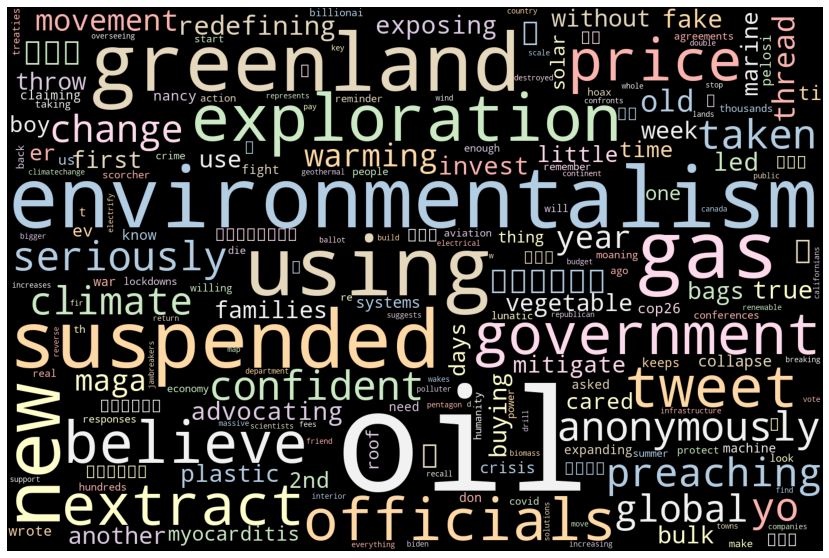

In [694]:
df_text_cleaned = clean_text(top100_tweets_with_retweet)
word_cloud(df_text_cleaned)

## Q6. Retweet, Like, and Reply Count by URL

In [695]:
def count_retweet_like_reply_by_url(df):
    df_with_url = df[['tweet_id','username','retweet_count','like_count','reply_count','url']].reset_index(drop=True)
    df_with_url['url_count'] = df_with_url['url'].str.len()
    df_with_url['with_url'] = np.where(df_with_url['url_count']==0, 'Without URL','With URL')
    return df_with_url.groupby(['with_url']).sum().drop('url_count',axis=1).reset_index(level=0)

count_retweet_like_reply_by_url = count_retweet_like_reply_by_url(final_df)
count_retweet_like_reply_by_url

,with_url,retweet_count,like_count,reply_count
0,With URL,17305,4,3
1,Without URL,191738,3,23


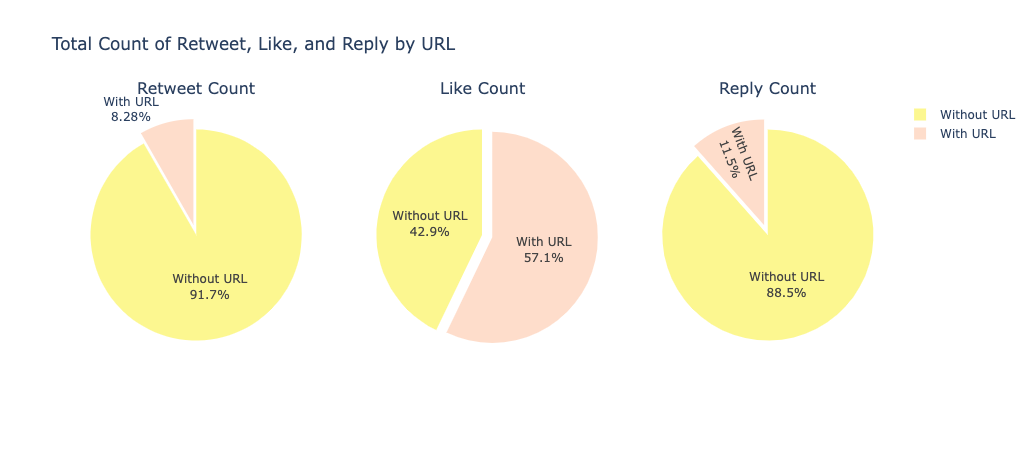

In [696]:
from plotly.subplots import make_subplots

labels = count_retweet_like_reply_by_url.with_url.tolist()
colors = ['#feddcb','#fcf790']

fig = make_subplots(1,3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]],
                   subplot_titles=['Retweet Count', 'Like Count', 'Reply Count'])
fig.add_trace(go.Pie(labels=labels, values=count_retweet_like_reply_by_url.retweet_count.tolist(), textinfo='label+percent', pull=[0.1, 0], scalegroup='one', marker_colors=colors,
                    name='Retweet Count by URL'), 1,1)
fig.add_trace(go.Pie(labels=labels, values=count_retweet_like_reply_by_url.like_count.tolist(), textinfo='label+percent', pull=[0.1, 0], scalegroup='two', marker_colors=colors,
                    name='Like Count by URL'), 1,2)
fig.add_trace(go.Pie(labels=labels, values=count_retweet_like_reply_by_url.reply_count.tolist(), textinfo='label+percent', pull=[0.1, 0], scalegroup='three', marker_colors=colors,
                    name='Reply Count by URL'), 1,3)

fig.update_layout(title_text='Total Count of Retweet, Like, and Reply by URL')
fig.show()

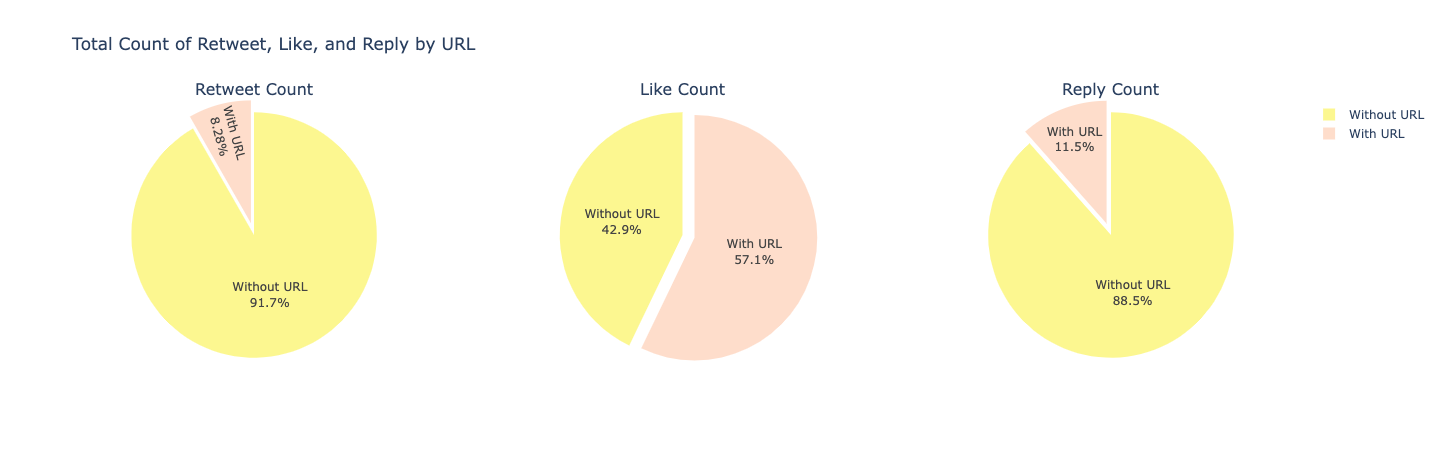

In [697]:
display.Image('Images/triple_piechart_url.png')

**Findings:**<br>
In our sample dataset, we saw tweets which did not have url links were replied-to and retweeted at a higher frequency than those which did have a url.  There was an estimated 77% difference in the reply rate for tweets without urls versus those with urls. In addition, there was an estimated 83% difference in the retweet rate for tweets without urls versus those with urls. In contrast, we observed that the like count for tweets with urls was 14% higher than those without urls.

## Q7. Retweet, Like, and Reply Count by Hashtag

In [698]:
def count_retweet_like_reply_by_hashtag(df):
    df_with_hashtag = df[['tweet_id','username','retweet_count','like_count','reply_count','hashtag_name']].reset_index(drop=True)
    df_with_hashtag['hashtag_count'] = df_with_hashtag['hashtag_name'].str.len()
    df_with_hashtag['with_hashtag'] = np.where(df_with_hashtag['hashtag_count']==0, 'Without Hashtag','With Hashtag')
    return df_with_hashtag.groupby(['with_hashtag']).sum().drop('hashtag_count',axis=1).reset_index(level=0)

count_retweet_like_reply_by_hashtag = count_retweet_like_reply_by_hashtag(final_df)
count_retweet_like_reply_by_hashtag

,with_hashtag,retweet_count,like_count,reply_count
0,With Hashtag,45623,2,0
1,Without Hashtag,163420,5,26


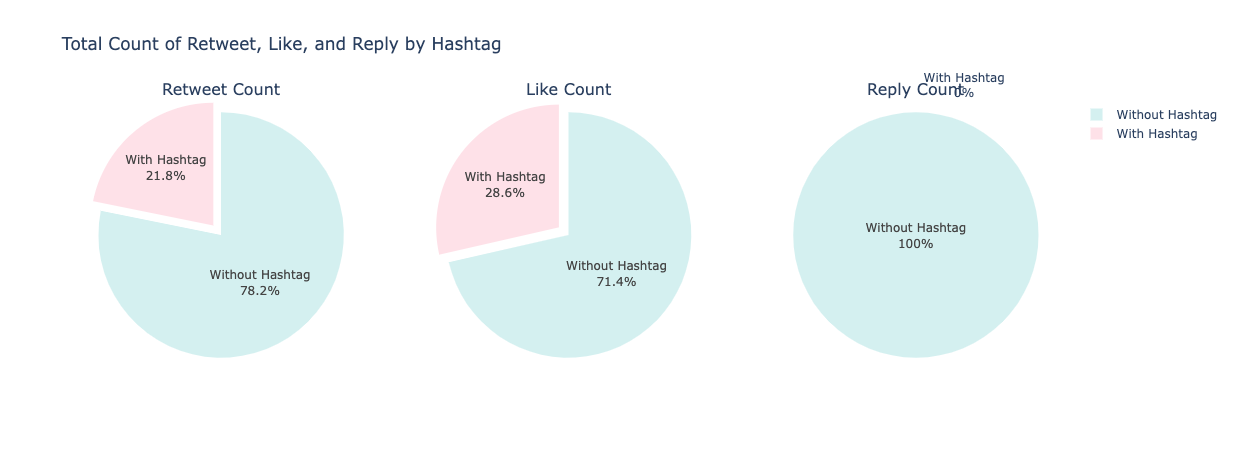

In [699]:
labels = count_retweet_like_reply_by_hashtag.with_hashtag.tolist()
colors = ['#fee1e8', '#d4f0f0']

fig = make_subplots(1,3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]],
                   subplot_titles=['Retweet Count', 'Like Count', 'Reply Count'])
fig.add_trace(go.Pie(labels=labels, values=count_retweet_like_reply_by_hashtag.retweet_count.tolist(), textinfo='label+percent', pull=[0.1, 0], scalegroup='one', marker_colors=colors,
                    name='Retweet Count by Hashtag'), 1,1)
fig.add_trace(go.Pie(labels=labels, values=count_retweet_like_reply_by_hashtag.like_count.tolist(), textinfo='label+percent', pull=[0.1, 0], scalegroup='two', marker_colors=colors,
                    name='Like Count by Hashtag'), 1,2)
fig.add_trace(go.Pie(labels=labels, values=count_retweet_like_reply_by_hashtag.reply_count.tolist(), textinfo='label+percent', pull=[0.1, 0], scalegroup='three', marker_colors=colors,
                    name='Reply Count by Hashtag'), 1,3)

fig.update_layout(title_text='Total Count of Retweet, Like, and Reply by Hashtag')
fig.show()

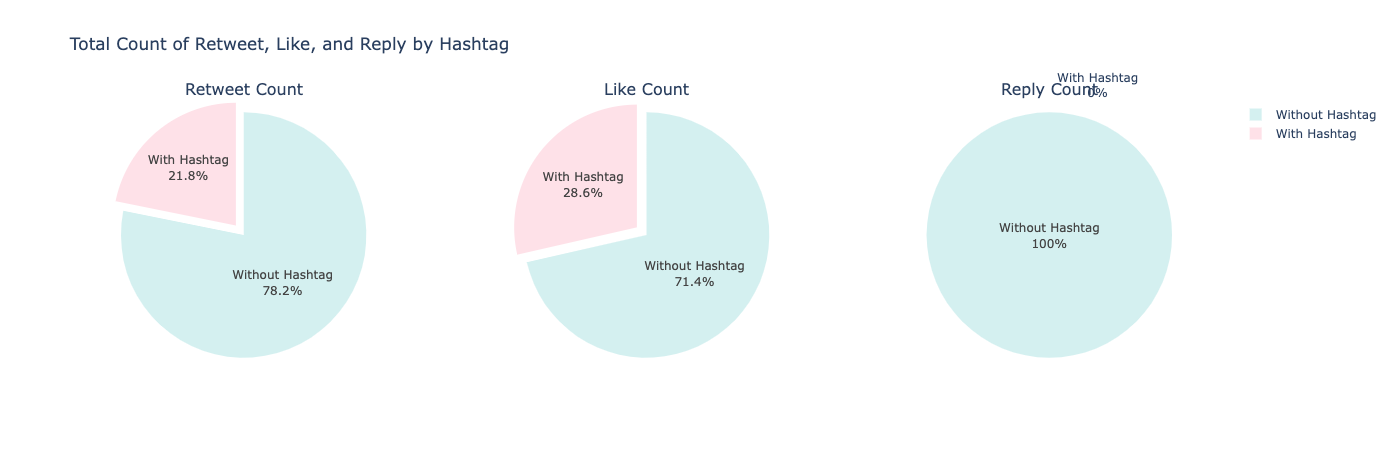

In [700]:
display.Image('Images/triple_piechart_hashtag.png')

**Findings:**<br>
Our observations using our sample dataset for tweets with or without hashtags were as follows: tweets without hashtags were retweeted, like and replied-to at higher rates than tweets with hashtags. There was a 56% difference in retweet rate, a 43% difference in like counts, and a 100% difference in reply counts for tweets without hashtags versus those with hashtags.

## Q8. Percentage of Tweets with "HappeningNow OR Happening" Hashtags versus Total Tweets

In [701]:
happening_now = final_df.hashtag_name.str.lower().str.contains(r'happeningnow|happening').sum() 
print("Happening Now Tweets", happening_now)

total_uniq_tweets = final_df['tweet_id'].nunique()

print("Total Tweets", total_uniq_tweets)
print("Percentage of tweets where there may be actual action {:.4f}%".format(happening_now/total_uniq_tweets * 100))

Happening Now Tweets 1
Total Tweets 2453
Percentage of tweets where there may be actual action 0.0408%
